# Applying classifiers to Shalek2013

We're going to use the classifier knowledge that we've learned so far and apply it to the shalek2013 and macaulay2016 datasets.

For the GO analysis, we'll need a few other packages:

* `mygene` for looking up the gene ontology categories of genes
* `goatools` for performing gene ontology enrichment analysis
* `fishers_exact_test` for `goatools`

Use the following commands at your terminal to install the packages. Some of them are on Github so it's important to get the whole command right.

```
$ pip install mygene
$ pip install git+git://github.com/olgabot/goatools.git
$ pip install git+https://github.com/brentp/fishers_exact_test.git
```

In [3]:
# Alphabetical order is standard
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Python plotting library
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Label processing
from sklearn import preprocessing

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Classification
from sklearn.svm import SVC

# Gene ontology
import goatools
import mygene

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline


Utility functions for gene ontology

In [4]:
GO_KEYS = 'go.BP', 'go.MF', 'go.CC'

def parse_mygene_output(mygene_output):
    """Convert mygene.querymany output to a gene id to go term mapping (dictionary)
    
    Parameters
    ----------
    mygene_output : dict or list
        Dictionary (returnall=True) or list (returnall=False) of 
        output from mygene.querymany
        
    Output
    ------
    gene_name_to_go : dict
        Mapping of gene name to a set of GO ids    
    """
    # if "returnall=True" was specified, need to get just the "out" key
    if isinstance(mygene_output, dict):
        mygene_output = mygene_output['out']

    gene_name_to_go = collections.defaultdict(set)

    for line in mygene_output:
        gene_name = line['query']
        for go_key in GO_KEYS:
            try:
                go_terms = line[go_key]
            except KeyError:
                continue
            if isinstance(go_terms, dict):
                go_ids = set([go_terms['id']])
            else:
                go_ids = set(x['id'] for x in go_terms)
            gene_name_to_go[gene_name] |= go_ids
    return gene_name_to_go


## Read in the Shalek2013 data and classify it

In [5]:
metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

# creating new column indicating color
metadata['color'] = metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
metadata.loc[metadata['pooled'], 'color'] = 'black'

# Create a column indicating both maturity and pooled for coloring with seaborn, e.g. sns.pairplot
metadata['group'] = metadata['maturity']
metadata.loc[metadata['pooled'], 'group'] = 'pooled'

# Create a palette and ordering for using with sns.pairplot
palette = ['MediumTurquoise', 'Teal', 'black']
order = ['immature', 'mature', 'pooled']


singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]

# Use only the genes that are substantially expressed in single cells

singles = singles.loc[:, (singles > 1).sum() >= 3]
singles.shape

# Now because computers only understand numbers, we'll convert the 
# category label of "mature" and "immature" into integers to a using a 
# `LabelEncoder`. Let's look at that column again, only for mature cells:

singles_maturity = metadata.loc[singles.index, 'maturity']

# Instantiate the encoder
encoder = preprocessing.LabelEncoder()

# Get number of categories and transform "mature"/"immature" to numbers
target = encoder.fit_transform(singles_maturity)

## Run the classifier!!

# Yay so now we can run a classifier!


classifier = SVC(kernel='linear')
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Make the `coefficients` series

In [6]:
coefficients = pd.Series(classifier.coef_.flat, index=singles.columns)
coefficients.head()

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


NPL        -1.387786e-04
QK          1.543810e-04
AK163153    3.543145e-04
AGPAT4     -4.594230e-04
IGF2R       2.282964e-07
dtype: float64

Let's remind ourselves of the distribution of the coefficients again

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


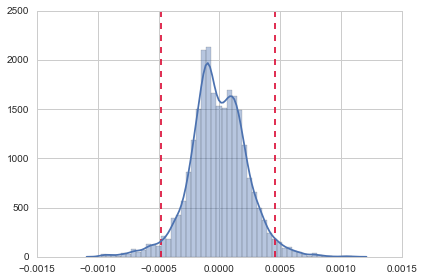

In [7]:
mean = coefficients.mean()
std = coefficients.std()
multiplier = 2
lower_cutoff = mean - multiplier * std
upper_cutoff = mean + multiplier * std

fig, ax = plt.subplots()
sns.distplot(coefficients)

# Add vertical lines
ymin, ymax = ax.get_ylim()
ax.vlines([lower_cutoff, upper_cutoff], ymin, ymax, linestyle='--', color='Crimson')

In [15]:
below_cutoff = coefficients[coefficients < lower_cutoff]
print(below_cutoff.shape)
below_cutoff.head()

(172,)


FPR1    -0.000507
FPR2    -0.000580
PRDX6   -0.000543
MYO1F   -0.000872
TNF     -0.000727
dtype: float64

How can we ***biologically*** assess what genes are found by our classifier? One way is through Gene Ontology enrichment

## Evaluating classifiers through Gene Ontology (GO) Enrichment

Gene ontology is a tree (aka directed acyclic graph or "dag") of gene annotations. The topmost node is the most general, and the bottommost nodes are the most specific. Here is an example GO graph.

![](figures/example_go_graph.png)

Three GO Domains:

* Cellular Component (CC)
* Molecular Function (MF)
* Biological Process (BP)

### Perform GO enrichment analysis (GOEA)


#### GOEA Step 1: Download GO graph file of "obo" type (same for all species)

This will download the file `"go-basic.obo"` if it doesn't already exist. This only needs to be done once.

In [8]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# Show the filename
obo_fname

  EXISTS: go-basic.obo


'go-basic.obo'

#### GOEA Step 2: Create the GO graph (same for all species)

(this may take some time to build the graph)

In [10]:
obo_dag = goatools.obo_parser.GODag(obo_file=obo_fname)

load obo file go-basic.obo


go-basic.obo: format-version(1.2) data-version(releases/2016-06-15)


46823 nodes imported


#### GOEA Step 3: Get gene ID to GO id mapping (species-specific and experiment-specific)

Here we are establishing the background for our GOEA. Defining your background is **very important** because, for example, tehre are lots of neural genes so if you use all human genes as background in your study of which genes are upregulated in Neuron Type X vs Neuron Type Y, you'll get a bunch of neuron genes (which is true) but not the smaller differences between X and Y. Typicall, you use *all expressed genes* as the background.

For our data, we can access all expressed genes very simply by getting the column names in the dataframe: `singles.columns`, which is the dataframe we used for classifying and shows *all expressed genes in single cells.* This will be our background.

In [12]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(singles.columns, 
                             scopes='symbol', fields=['go.BP', 'go.MF', 'go.CC'], species='mouse', 
                             returnall=True)

gene_name_to_go = parse_mygene_output(mygene_output)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-6013...done.
Finished.
107 input query terms found dup hits:
	[('C330024D21RIK', 2), ('A230072C01RIK', 2), ('MARCKSL1-PS4', 2), ('SLFN10-PS', 2), ('GM9104', 2), (
737 input query terms found no hit:
	['AK163153', 'AK036897', 'AK138383', 'AK164875', 'AK043564', 'AK134158', 'GM4769', '1110058L19RIK', 


#### GOEA Step 4: Create a GO enrichment calculator object `go_enricher` (species- and experiment-specific)

In this step, we are using the two objects we've created (`obo_dag` from Step 2 and `gene_name_to_go` from Step 3) plus the gene ids to create a `go_enricher` object

In [13]:
go_enricher = goatools.GOEnrichmentStudy(singles.columns, gene_name_to_go, obo_dag)

Propagating term counts to parents ..


 5,203 out of  6,013 population items found in association


#### GOEA Step 5: Calculate go enrichment!!! (species- and experiment-specific)

Now we are ready to run go enrichment!! Let's take our enriched genes of interest and run the enrichment analysis!

In [20]:
genes_of_interest = below_cutoff.index

# "results" is a list and is annoying to deal with ... 
# ... so we'll make a dataframe in the next step
results = go_enricher.run_study(genes_of_interest)

# Create a dataframe of the results so it's easier to deal with
below_cutoff_go_enrichment = pd.DataFrame([r.__dict__ for r in results])
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

Calculating uncorrected p-values using fisher
   158 out of    172 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
15,184 GO terms are associated with 158 of 172 study items in a population of 6,013
(15184, 18)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
0,GO:0050715,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050715\tlevel-06\tdepth-09\tpositive regul...,positive regulation of cytokine secretion,0.002858,0.002858,0.002786,1.882570e-07,42,"{NLRP1A, IFNAR1, UNC93B1, CD274, MIF, TNFSF15,...",6013,"(42, 6013)","(12, 172)",12,"{CLEC5A, CLEC4E, CD84, CSF1R, TLR2, TNF, CLEC4...",172
1,GO:0070372,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0070372\tlevel-07\tdepth-10\tregulation of ...,regulation of ERK1 and ERK2 cascade,0.004224,0.004224,0.004118,2.782195e-07,79,"{CLCF1, FN1, TIRAP, TREM2, CCL4, MIF, SLC9A3R1...",6013,"(79, 6013)","(13, 172)",13,"{C5AR1, CCR1, DAB2, CCL4, TREM2, DYNLT1B, CSF1...",172
2,GO:0050727,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050727\tlevel-05\tdepth-06\tregulation of ...,regulation of inflammatory response,0.004417,0.004416,0.004306,2.909038e-07,107,"{GBP5, CCR2, SIGLECE, SPN, METRNL, NFKB1, CASP...",6013,"(107, 6013)","(15, 172)",15,"{ACP5, CCL4, IL1R2, FCGR2B, FCGR3, PYCARD, TLR...",172
3,GO:0032760,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0032760\tlevel-07\tdepth-07\tpositive regul...,positive regulation of tumor necrosis factor p...,0.004587,0.004586,0.004471,3.021031e-07,44,"{TICAM1, TIRAP, CCR2, CCL4, SPN, FCGR3, SASH3,...",6013,"(44, 6013)","(10, 172)",10,"{CCL4, HSPD1, CD84, FCGR3, PYCARD, TLR2, CCL2,...",172
4,GO:0045087,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0045087\tlevel-03\tdepth-04\tinnate immune ...,innate immune response,0.004627,0.004625,0.004510,3.047053e-07,154,"{IL1F9, HCK, NFKB1, SLPI, CYBA, RPL39, SH2D1B1...",6013,"(154, 6013)","(19, 172)",19,"{CLEC5A, CLEC4E, TREM2, CD84, CD14, CSF1R, TLR...",172


Now we're going to ..... say it with me ...... **add a column!** that is the negative log10 of the p-value so it's easier to plot and deal with.

In [ ]:
below_cutoff_go_enrichment['log10_p_bonferroni'] = -np.log10(below_cutoff_go_enrichment['p_bonferroni'])
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

Let's make sure this dataframe is sorted in order of enrichment. By default, this is sorting in *ascending* order, and we want the most enriched to be at the top, so let's say `ascending=False`.

In [ ]:
below_cutoff_go_enrichment = below_cutoff_go_enrichment.sort_values('log10_p_bonferroni', ascending=False)
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

Let's look at the distribution of the log10 p-values

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


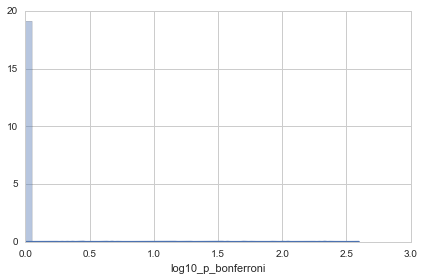

In [31]:
sns.distplot(below_cutoff_go_enrichment['log10_p_bonferroni'])

Now we can also plot this data! Let's just take a subset, say the first 10 and look at the distribution of p-values here.

In [ ]:
below_cutoff_go_enrichment_subset = below_cutoff_go_enrichment.iloc[:10, :]

sns.distplot(below_cutoff_go_enrichment_subset['log10_p_bonferroni'])

Now let's plot the GO categories! We want to make sure they stay in the highest-lowest order by specifying "order" (otherwise they will be alphabetical!)

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


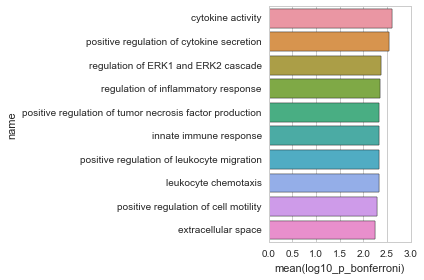

In [33]:
order = below_cutoff_go_enrichment_subset['name']

fig, ax = plt.subplots()
sns.barplot(x='log10_p_bonferroni', y='name', data=below_cutoff_go_enrichment_subset, orient='h', order=order)
fig.savefig("below_cutoff_go_enrichment.pdf")

### Exercise

1. Perform GO enrichment on the genes ABOVE the upper cutoff.
2. Plot the enrichment as a bar graph.
4. Try using only the LPS response genes for classification, and calculate GO enrichment on those, too. Do you have to change the background as well?

Use the cells below.

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE